M3. Improve BoVW with SVM's
--

In [1]:
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from utils.CodeTimer import CodeTimer
from utils.DatasetManager import DatasetManager
from descriptors.SIFT import DenseSIFT as DenseSIFT_
from descriptors.SIFT import DenseSIFTPyramid as DenseSIFTPyramid_
from descriptors.VisualWords import VisualWords as VisualWords_
from descriptors.VisualWords import VisualWordsPyramid as VisualWordsPyramid_
from utils.Kernels import histogram_intersection_kernel
from utils.Normalizer import Normalizer as Normalizer_

In [2]:
dataset = DatasetManager(r"C:\Users\PC\Documents\Roger\Master\M3\Project\Databases\MIT_split")
train_img_paths, train_labels, test_img_paths, test_labels = dataset.load_dataset()
SAVE_PATH = r"C:\Users\PC\Documents\Roger\Master\M3\Project\GIT\Week2\SavePath"

Normalization
--

In [3]:
STEP_SIZE = 16
DESC_SIZE = [8,16]
n_cluster = 896
K_FOLDS = 5
param_grid = {'C': [1], 'kernel': [histogram_intersection_kernel], 'gamma': ['scale']}
NORMALIZATIONS = ["l1","l2","power"]
results_test = []
results_train = []

DenseSIFTPyramid = DenseSIFTPyramid_()
scaler = StandardScaler()
VisualWordsPyramid = VisualWordsPyramid_(n_cluster)
Normalizer = Normalizer_()

train_desc_path = SAVE_PATH+os.sep+'desc'+os.sep+'train'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16.dat'
test_desc_path = SAVE_PATH+os.sep+'desc'+os.sep+'test'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16.dat'
train_data_path = SAVE_PATH+os.sep+'data'+os.sep+'train'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16.dat'
test_data_path = SAVE_PATH+os.sep+'data'+os.sep+'test'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16.dat'
if all(os.path.isfile(path) for path in [train_desc_path,test_desc_path,train_data_path,test_data_path]):
    train_desc = pickle.load(open(train_desc_path, 'rb'))
    test_desc = pickle.load(open(test_desc_path,'rb'))
    train_data = pickle.load(open(train_data_path,'rb'))
    test_data = pickle.load(open(test_data_path,'rb'))
else:
    with CodeTimer("Obtain training and test data"):
        # Compute DenseSIFT descriptors for train and test sets
        train_desc = DenseSIFTPyramid.compute(train_img_paths, STEP_SIZE, DESC_SIZE, 2)
        test_desc = DenseSIFTPyramid.compute(test_img_paths, STEP_SIZE, DESC_SIZE, 2)
        # Save computed data
        pickle.dump(train_desc, open(train_desc_path, 'wb'))
        pickle.dump(test_desc, open(test_desc_path, 'wb'))
        # Obtain visual words for train and test sets
        VisualWordsPyramid.fit(train_desc)
        train_data = VisualWordsPyramid.get_visual_words(train_desc)
        test_data = VisualWordsPyramid.get_visual_words(test_desc)
        # Save computed data
        pickle.dump(train_data, open(train_data_path, 'wb'))
        pickle.dump(test_data, open(test_data_path, 'wb'))
for norm in NORMALIZATIONS:
    # Normalize data
    train_data_norm = Normalizer.normalize(train_data, norm)
    test_data_norm = Normalizer.normalize(test_data, norm)
    # Scale data
    train_data_norm = scaler.fit_transform(train_data_norm)
    test_data_norm = scaler.transform(test_data_norm)
    # Train SVM with cross-validation 5-fold
    with CodeTimer("Train SVM"):
        cv = GridSearchCV(SVC(), param_grid=param_grid, cv=K_FOLDS)
        cv.fit(train_data_norm, train_labels)
    # Test SVM
    with CodeTimer("Test SVM"):
        results_train.append(cv.score(train_data_norm, train_labels)) 
        results_test.append(cv.score(test_data_norm, test_labels)) 

Train SVM: 598.7332601547241 s
Test SVM: 234.7728555202484 s
Train SVM: 564.654415845871 s
Test SVM: 161.00382494926453 s
Train SVM: 573.0365097522736 s
Test SVM: 161.2187213897705 s


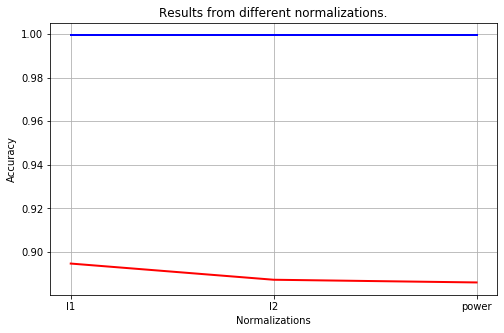

In [4]:
plt.figure(figsize=(8, 5))
plt.title('Results from different normalizations.')
plt.plot(NORMALIZATIONS,results_train,'b',linewidth=2,label='Test')
plt.plot(NORMALIZATIONS,results_test,'r',linewidth=2,label='Train')
plt.ylabel('Accuracy')
plt.xlabel('Normalizations')
plt.grid(True)
plt.show()

In [5]:
print(results_train)
print(results_test)

[0.9994683678894205, 0.9994683678894205, 0.9994683678894205]
[0.8946716232961586, 0.8872366790582404, 0.885997521685254]


We can observe that the three normalizations produce similar results. However, in our case, aplying l1 normalization or no normalization at all produces the best results, therefore, we would stick with the l1 normalization in this case.